# 1 Import libraries

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score


import ETFs as etfs

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers



Total number of ETFs: 33


# 2 Read Data

In [2]:
data = pd.read_csv('../../dataProcessing/assets_filled.csv', parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
# display(data)


In [3]:
binary_targets = pd.read_csv('../../dataProcessing/target_binary.csv', parse_dates=['Date'])
binary_targets.set_index('Date', inplace=True)

# 3. Splitting the data

In [4]:
dataset_size = len(data)
train_size = int(dataset_size * 0.7)
test_size = int(dataset_size * 0.2)
val_size = dataset_size - train_size - test_size

train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size + val_size]
test_data = data.iloc[train_size + val_size:]

binary_targets_train = binary_targets.iloc[:train_size]
binary_targets_val = binary_targets.iloc[train_size:train_size + val_size]
binary_targets_test = binary_targets.iloc[train_size + val_size:]

# 4. Create rolling windows

In [5]:
def create_X_y_rolling(df, target_label, window_size):
    X, y, labels, first_values = [], [], [], []
    for i in range(len(df) - window_size):
        window = df.iloc[i:i+window_size]
        first_value = window.iloc[0]
        normalized_window = window / first_value  
        X.append(normalized_window.values)
        
        y_target = df.iloc[i+window_size] / first_value  
        y.append(y_target.values)
        
        l = target_label.iloc[i+window_size]
        labels.append(l)
        
        first_values.append(first_value.values) 
        
    X = np.array(X)
    y = np.array(y)
    first_values = np.array(first_values)
    labels = np.array(labels)
    return X, y, first_values, labels

# 5. Creating train, val, test rolling windows

In [6]:
window_size = 30


X_train, y_train, first_values_train, labels_train = create_X_y_rolling(train_data, binary_targets_train, window_size)
X_val, y_val, first_values_val, labels_val = create_X_y_rolling(val_data, binary_targets_val, window_size)
X_test, y_test, first_values_test, labels_test = create_X_y_rolling(test_data, binary_targets_test, window_size)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape, labels_train.shape, labels_val.shape, labels_test.shape


((2355, 30, 33),
 (2355, 33),
 (312, 30, 33),
 (312, 33),
 (651, 30, 33),
 (651, 33),
 (2355, 33),
 (312, 33),
 (651, 33))

# 6. Train the model

In [ ]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2), 

    LSTM(64, return_sequences=False),
    Dropout(0.2),  

    Dense(y_train.shape[1] )
])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=[MeanSquaredError()])

cp = ModelCheckpoint(filepath='model_regression/best_LSTM.keras', save_best_only=True, monitor='val_loss', mode='min')
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[cp, es],
)
# model.summary()



c:\Users\Shelly\Desktop\BachelorProject\BAvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.4083 - mean_squared_error: 0.4082 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0679 - mean_squared_error: 0.0679 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0482 - mean_squared_error: 0.0482 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0379 - mean_squared_error: 0.0379 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0319 - mean_squared_error: 0.0319 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0270 - mean_squared_error: 0.0270 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0243 - mean_squared_error: 0.0243 - val_loss: 0.00

# 7. Plot the loss

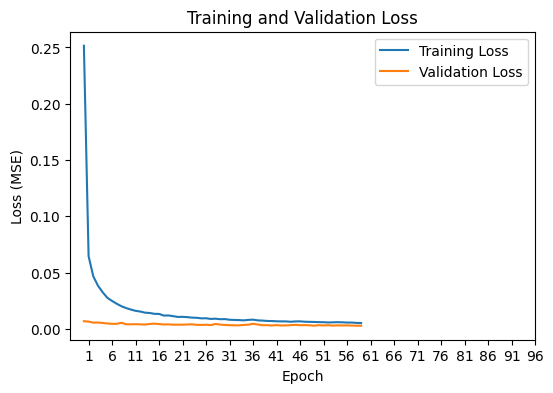

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['mean_squared_error'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
xticks = np.arange(1, 100, 5)
plt.xticks(xticks)
plt.title('Training and Validation Loss')
plt.show()

# 8. Predict the testing dataset

In [ ]:
model = load_model('model_regression/best_LSTM.keras')
index_series = data.index[-len(y_test):]  

Y_pred = model.predict(X_test)
Y_pred_denorm = Y_pred * first_values_test  

Predict_result_df = pd.DataFrame(Y_pred_denorm, index=index_series, columns=data.columns)

# display(Predict_result_df)

# Predict_result_df["SPY"].plot()


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [ ]:
# Y_pred

# 9. Summary and evaluation

In [ ]:
# SUMMARY
y_test_denorm = y_test * first_values_test
y_actual = pd.DataFrame(y_test_denorm, index=index_series, columns=data.columns)


mae = mean_absolute_error(y_test, Y_pred)
mse = mean_squared_error(y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, Y_pred)

print(f"Mean Absolute Error: {mae:.4f}" )
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error: 0.0375
Mean Squared Error: 0.0026
Root Mean Squared: 0.0513
R² Score: 0.4244


# 10. Visualize some assets

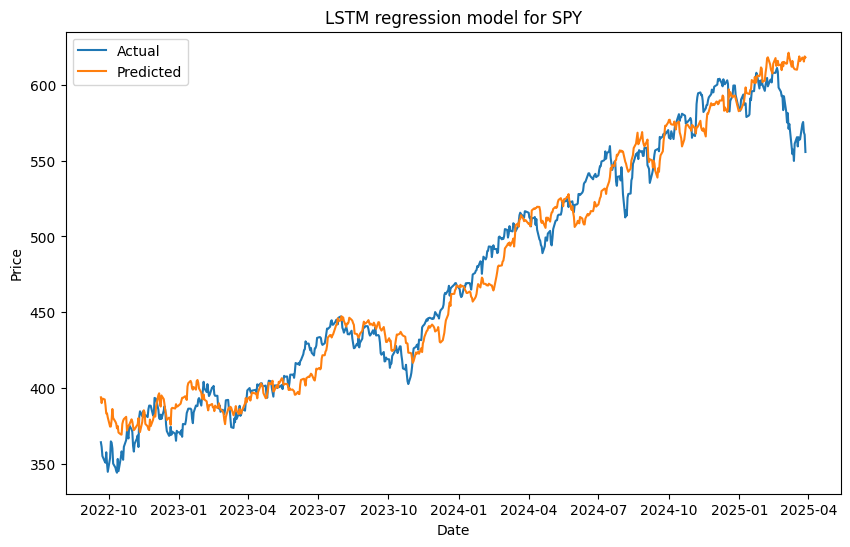

In [ ]:
ticker_name = 'SPY'
plt.figure(figsize=(10,6))
plt.plot(y_actual[ticker_name], label='Actual')
plt.plot(Predict_result_df[ticker_name], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'LSTM regression model for {ticker_name}')
plt.legend()
plt.show()

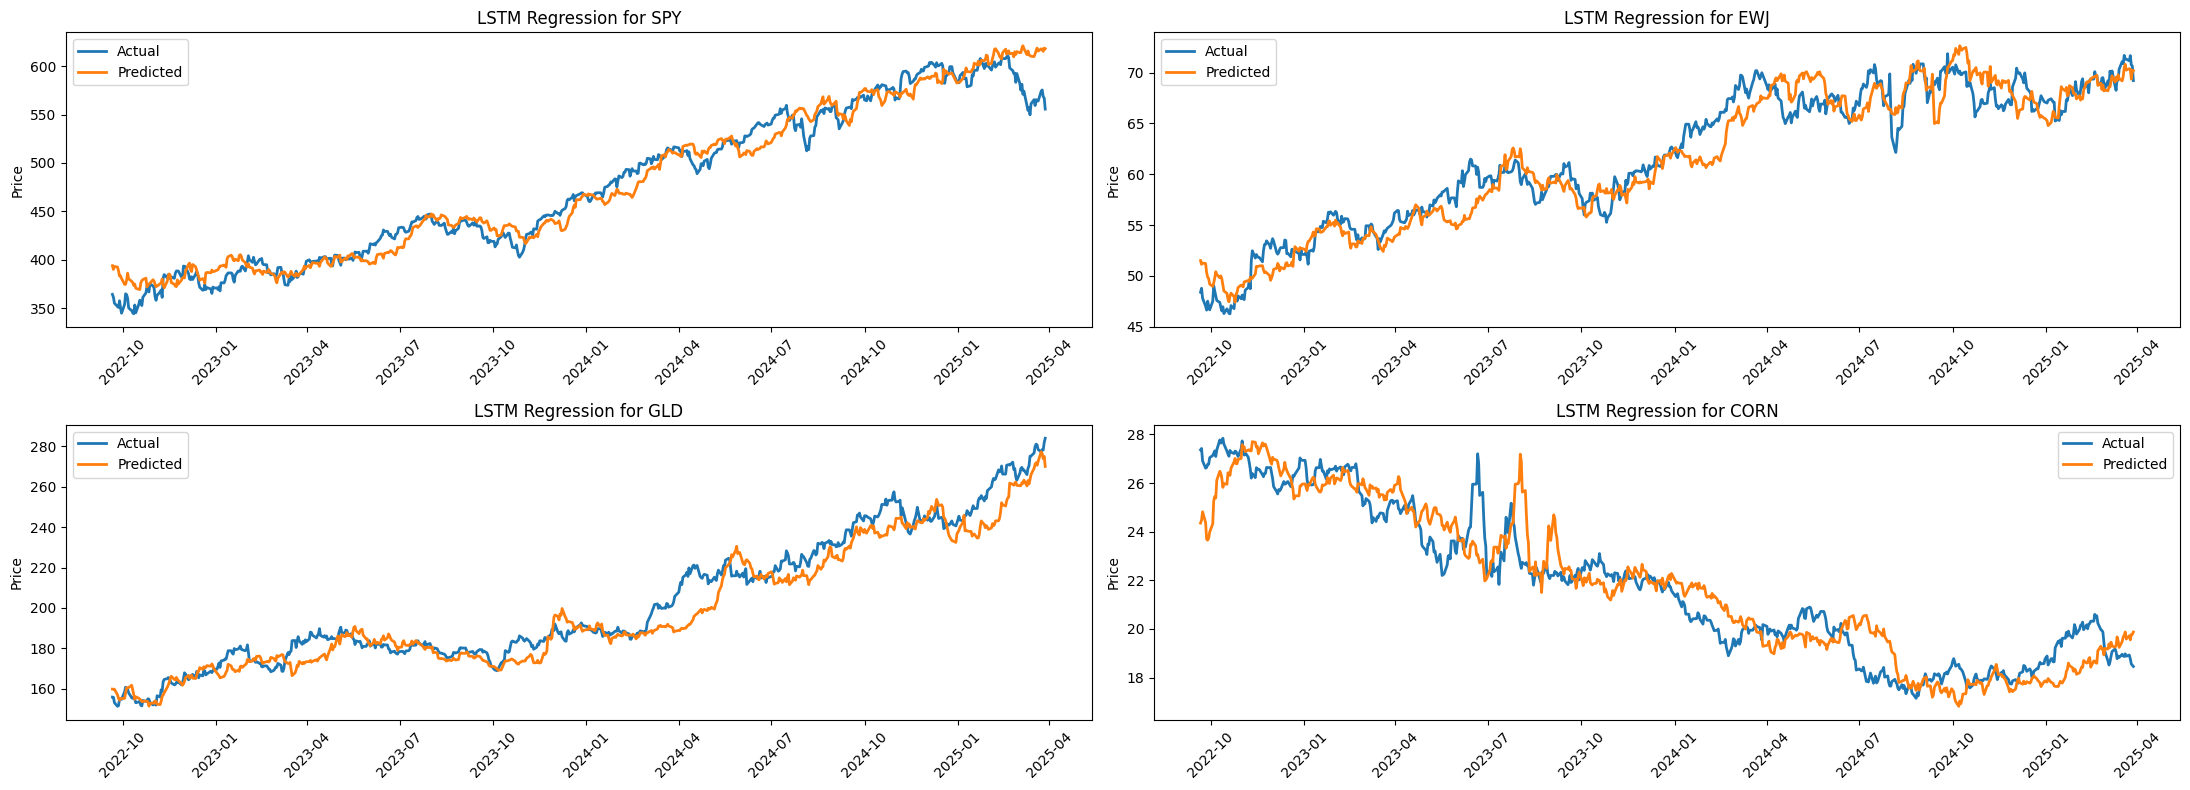

In [ ]:
ticker_name = ['SPY', 'EWJ', 'GLD', 'CORN']  

num_plots = len(ticker_name)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols


fig, axes = plt.subplots(num_rows, num_cols, figsize=(22, 8))
axes = axes.flatten() 


for i, ticker in enumerate(ticker_name):
    ax = axes[i]
    ax.plot(y_actual[ticker], label='Actual', linewidth=2)
    ax.plot(Predict_result_df[ticker], label='Predicted', linewidth=2)
    ax.set_title(f'LSTM Regression for {ticker}')
    ax.set_ylabel('Price')
    ax.tick_params(axis='x', rotation=45)

    ax.legend()

for j in range(len(ticker_name), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



In [ ]:
# data

In [ ]:
labels_test_df = pd.DataFrame(labels_test, index=index_series, columns=data.columns)
# labels_test_df

In [ ]:
# display(labels_test_df["SPY"])

In [ ]:
# Predict_result_df

# 11 Compute the accuracy of the price movement for the testing dataset

In [ ]:
y_test_shift = data[-len(y_test) - 1: -1]
y_test_shift_index = data.index[-len(y_test) - 1: -1]

y_test_shift_df = pd.DataFrame(y_test_shift, index=y_test_shift_index, columns=data.columns)
y_test_shift_array = y_test_shift_df.values


predicted_directions = (Y_pred_denorm > y_test_shift_array).astype(int)
predicted_directions_df = pd.DataFrame(predicted_directions, index=index_series, columns=data.columns)
# display(predicted_directions_df)


In [ ]:
actual_flat = labels_test_df.to_numpy().flatten()
predicted_flat = predicted_directions_df.to_numpy().flatten()

matches = np.sum(actual_flat == predicted_flat)
percentage = (matches / len(actual_flat)) * 100
print(f"Match Percentage: {percentage:.2f}%")

accuracy = accuracy_score(actual_flat, predicted_flat)
print(f'Accuracy of the model: {accuracy:.4f}')

Match Percentage: 50.18%
Accuracy of the model: 0.5018
